In [1]:
#using Pkg; Pkg.add("Plots")

using ITensors
using Plots
using QuadGK # for 1D integrals
        #example: quadgk(x -> exp(-x^2), 0, 1, rtol=1e-8)
using LinearAlgebra
using LaTeXStrings # L"string" to print "string" as latex
#using LsqFit # for nonlinear fit https://julianlsolvers.github.io/LsqFit.jl/latest/tutorial/

using Polynomials #there is a function `fit(xdata,ydata,polynomial_degree)` to do polynomial regression. 
                    #Source: https://www.geeksforgeeks.org/polynomial-regression-in-julia/
using LsqFit #for nonlinear fits
using Dates #to use the function now()
using CSV
#using HDF5 #to save weird objects
using JLD2
using DataFrames

In [2]:
Threads.nthreads()

1

# Importing data

In the following cell we define the evolution with the Hamiltonian

$$
H= \sum_{j=1}^{L-n} \sum_{\alpha\in\{x,y\}}\sum_{d=1}^n J_{d}^\alpha \sigma_{j}^\alpha \sigma_{j+d}^\alpha
+ g\sum_{j=2}^{L-n} \sigma^x_j \sigma^z_{j+1} - g\sum_{j=1}^{L-1-n} \sigma^z_j \sigma^x_{j+1},
$$
where $J_n^{\alpha}=J^{\alpha} g_n$ and $J^{x}\geq J^{y}$ and $J_x = J_y$.


 
I have the following options for the parameters:

In [ ]:
nmax = 1

Jx = 0.25 
Jz = round(1 * Jx, digits=2)
g = round(0.4 * Jx, digits=2)

dt = 0.01;

Ls = [80]
bDs = [100];

In [ ]:
nmax = 2

Jx = 0.25 
Jz = round(1 * Jx, digits=2)
g = round(0.4 * Jx, digits=2)

dt = 0.01;

Ls = [80]
bDs = [100, 160];

In [ ]:
nmax = 2

Jx = 0.25 
Jz = round(0.4 * Jx, digits=2)
g = round(0.7 * Jx, digits=2)

dt = 0.01;

Ls = [120]
bDs = [100, 160];

In [3]:
nmax = 2

Jx = 0.25 
Jz = round(0.4 * Jx, digits=2)
g = round(0.8 * Jx, digits=2)

dt = 0.01;

Ls = [200]
bDs = [160,240];

In [ ]:
nmax = 2

Jx = 0.25 
Jz = round(0.2 * Jx, digits=2)
g = round(0.3 * Jx, digits=2)

dt = 0.01;

Ls = [80]
bDs = [160];

In [ ]:
nmax = 2

Jx = 0.25 
Jz = round(0.4 * Jx, digits=2)
g = round(0.5 * Jx, digits=2)

dt = 0.01;

Ls = [80]
bDs = [160];

In [33]:
nmax = 2

Jx = 0.25 
Jz = round(0.4 * Jx, digits=2)
g = round(1.5 * Jx, digits=2)

dt = 0.01;

Ls = [120]
bDs = [240, 300];

In [2]:
# it's in the PAPER right now
nmax = 2

Jx = 0.25 
Jz = round(0.4 * Jx, digits=2)
g = round(0.9 * Jx, digits=2)

dt = 0.01;

Ls = [110]
bDs = [400, 460];

In [5]:
nmax = 2

Jx = 0.25 
Jz = 0.1
g = 0.2

dt = 0.01;

Ls = [100]
bDs = [500, 600];

In [3]:
# for laptop:
#base_path = "/Users/saveriobocini/numerics_PhD/longrange/XXZ";

# for desktop
base_path = "/home/sbocini/Numerics_LabDesktop/longrange/XXZ";

We'll construct the table

|  | bD1 | bD2 | bD3 |
| --- | --- | --- | ---|
| **L1** | 
| **L2**
| **L3**



In [4]:
tabb = [[["$(colons)","$(rows)"] for rows in bDs] for colons in Ls]

1-element Vector{Vector{Vector{String}}}:
 [["110", "400"], ["110", "460"]]

In [4]:
times = [
    load("$(base_path)/n$(nmax)_L$(L)_Jx$(Jx)_Jz$(Jz)_g$(g)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
    ];

states = [
    [
        [
            load("$(base_path)/n$(nmax)_L$(Ls[k])_Jx$(Jx)_Jz$(Jz)_g$(g)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

# Observables definition

Here I define a function to compute the Hamiltonian density.
It works for $i\in\{2,...,L-2\}$.

In [5]:
function hamiltonian_density(state, i, J=J, g=g)
    
    if i==1 || (i > length(state) - 1)
        throw(DomainError(i, "Trying to go beyond boundaries."))
    end
    
    outpu = ComplexF64(0)
    
    orthogonalize!(state, i-1)
    
    op_site1 = -J * op(siteind(state, i-1), "Sz")
    op_site2 = 2 * op(siteind(state, i), "Sx")
    op_site3 = 2 * op(siteind(state, i+1), "Sx")
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); #indices (link,i-1) (link,i-1)' 
    C *= state[i]; #indices (link,i) (link,i-1)' (spin,i)
    C *= op_site2
    C *= dag(prime(prime(state[i], "Site"), "Link"));
    C *= state[i+1];
    C *= op_site3;
    il = commonind(state[i+1],state[i]);
    C *= dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[]
    
    
    op_site1 = -J * op(siteind(state, i-1), "Sx")
    op_site2 = 2 * op(siteind(state, i), "Sx")
    op_site3 = 2 * op(siteind(state, i+1), "Sz")
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); #indices (link,i-1) (link,i-1)' 
    C *= state[i]; #indices (link,i) (link,i-1)' (spin,i)
    C *= op_site2
    C *= dag(prime(prime(state[i], "Site"), "Link"));
    C *= state[i+1];
    C *= op_site3;
    il = commonind(state[i+1],state[i]);
    C *= dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[]
    
    
    op_site1 = J * op(siteind(state, i-1), "Sx") 
    op_site2 = 2 * op(siteind(state, i), "Sx") 
    C = state[i-1] #(link,i-2)(link,i-1)(spin,i-1)
    C *= op_site1 #(link,i-2)(link,i-1)(spin,i-1)'
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); #(link,i-1)(link,i-1)'
    C *= state[i]; #(link,i)(link,i-1)'(spin,i)
    C *= op_site2 #(link,i)(link,i-1)'(spin,i)'
    il = commonind(state[i-1], state[i]);
    C *= dag(prime(prime(state[i], "Site"), il)); 
    outpu += C[]
    
    
    op_site1 = -g * op(siteind(state, i-1), "Sz") 
    op_site2 = 2 * op(siteind(state, i), "Sy") 
    C = state[i-1] #(link,i-2)(link,i-1)(spin,i-1)
    C *= op_site1 #(link,i-2)(link,i-1)(spin,i-1)'
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); #(link,i-1)(link,i-1)'
    C *= state[i]; #(link,i)(link,i-1)'(spin,i)
    C *= op_site2 #(link,i)(link,i-1)'(spin,i)'
    il = commonind(state[i-1], state[i]);
    C *= dag(prime(prime(state[i], "Site"), il)); 
    outpu += C[]
    
    
    
    
    orthogonalize!(state, i)

    op_site1 = J * op(siteind(state, i), "Sx")
    op_site2 = 2 * op(siteind(state, i+1), "Sx")
    C = state[i] #indices (link i-1) (link,i) (spin,i)
    C *= op_site1 #indices (link i-1) (link,i) (spin,i)'
    ir = commonind(state[i], state[i+1]); 
    C *= dag(prime(prime(state[i], "Site"), ir)); #indices (link i) (link,i)' 
    C *= state[i+1]; #indices (link i+1) (link,i)' (spin,i+1)
    C *= op_site2 #indices (link i+1) (link,i)' (spin,i+1)'
    il = commonind(state[i], state[i+1]);
    C *= dag(prime(prime(state[i+1], "Site"), il)); 
    outpu += C[]
    
    
    op_site1 = -g * op(siteind(state, i), "Sy")
    op_site2 = 2 * op(siteind(state, i+1), "Sz")
    C = state[i] #indices (link i-1) (link,i) (spin,i)
    C *= op_site1 #indices (link i-1) (link,i) (spin,i)'
    ir = commonind(state[i], state[i+1]); 
    C *= dag(prime(prime(state[i], "Site"), ir)); #indices (link i) (link,i)' 
    C *= state[i+1]; #indices (link i+1) (link,i)' (spin,i+1)
    C *= op_site2 #indices (link i+1) (link,i)' (spin,i+1)'
    il = commonind(state[i], state[i+1]);
    C *= dag(prime(prime(state[i+1], "Site"), il)); 
    outpu += C[]

    
    
    outpu + 2g * expect(state, "Sy", sites=i)
end

hamiltonian_density (generic function with 3 methods)

In [6]:
function edge_energy(state)
    0
end

edge_energy (generic function with 1 method)

In [7]:
function SvN_of_half_chain(state)
    L = length(state)
    b = div(L,2)
    orthogonalize!(state, b)
    U,S,V = svd(state[b], (linkind(state, b-1), siteind(state,b)))
    SvN = 0.0
    for n=1:dim(S, 1)
      p = S[n,n]^2
      SvN -= p * log(p)
    end
    SvN
end
    

SvN_of_half_chain (generic function with 1 method)

In [8]:
function max_schm_vals(state)
    outpu = Float64[]
    for b = 1:length(state)-1
        orthogonalize!(state, b)
        U,S,V = svd(state[b], (linkind(state, b-1), siteind(state,b)))
        push!(outpu, S[1,1])
    end
    outpu.^2
end

max_schm_vals (generic function with 1 method)

In [9]:
function nonpurity_length(schmv, precisio=0.977)
    i = 0
    for sv in schmv
        if sv < precisio
            i += 1
        end
    end
    i
end

nonpurity_length (generic function with 2 methods)

In [10]:
#DOES NOT WORK YET

#=function H_tobeapplied(state)
    # IT HOLDS ONLY FOR n=2
    
    siti = siteinds(state)
    LL = length(state)
    
    ampo = AutoMPO()
    for j=2:LL-1
        ampo += 2Jx, "Sx",j-1, "Sx",j+1
        ampo += -4Jx, "Sx",j-1, "Sz",j, "Sx",j+1
        ampo += 2Jy, "Sy",j-1, "Sy",j+1
        ampo += -4Jy, "Sy",j-1, "Sz",j, "Sy",j+1
        ampo += 2Jz, "Sz",j-1, "Sz",j+1
        ampo += -4Jz, "Sz",j-1, "Sz",j, "Sz",j+1
        ampo += -2h, "Sz",j
    end
    ampo += -2h, "Sz",1
    ampo += -2h, "Sz",LL
    
    MPO(ampo, siti)
end=#

In [11]:
function XXcorr(GS,m,n)
# gives the spinX-spinX correlation function
    
    if m>n 
        throw(DomainError(n-m, "difference between boundaries must be nonnegative"))
    end
    
    orthogonalize!(GS,m)
    
    Sx_m = op(siteind(GS,m),"Sx")
    Sx_n = op(siteind(GS,n),"Sx")
    
    C = GS[m] #indices (link m-1) (link,m) (spin,m)
          #this selects the m-th tensor of the (un-conjugated) state
    C *= Sx_m #indices (link m-1) (link,m) (spin,m)'
          #this applies the operator Sz_m to the site that we selected on the line above
    
    ir = commonind(GS[m],GS[m+1]); 
    C *= dag(prime(prime(GS[m],"Site"),ir)); 
    
    for j in m+1:n-1
        C *= GS[j];
        C *= dag(prime(GS[j],"Link"));
       # print(C)
    end
    
    C *= GS[n];

    C *=  Sx_n;
    
    il = commonind(GS[n],GS[n-1]);
    C *=  dag(prime(prime(GS[n],"Site"),il));
        
    C[] 
end;

In [12]:
# Variance-covariance matrix

function VCM(state)
    LL = length(state)
    outpu = zeros(3LL,3LL)
    
    paulis = ["Sx","Sy","Sz"]
    
    sigmaexp = [expect(state, σp) for σp in paulis]
    
    for (ii, ope1)=enumerate(paulis),  (jj, ope2)=enumerate(paulis)
        provisory = correlation_matrix(state, ope1, ope2)
        for i=1:LL, j=1:LL
            outpu[LL*(ii-1) + i, LL*(jj-1) + j] = 4*real(provisory[i,j]) - 4*sigmaexp[ii][i]*sigmaexp[jj][j]
        end
    end
    
    outpu
end

VCM (generic function with 1 method)

# Entanglement growth between the two half chains

In [20]:
entropies = [
    [
        [
            SvN_of_half_chain(states[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

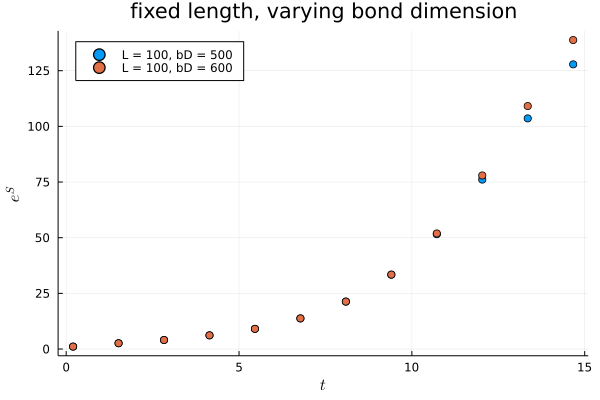

In [21]:
elle = length(Ls)
lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))
scatter(times[elle], [exp.(entropies[elle][j]) for j=1:length(bDs)]
    , label = lege
    , legend = :topleft
    , title = "fixed length, varying bond dimension"
    , ylabel = L"e^S"
    , xlabel = L"t"
)



In [18]:
#savefig("./img/FIGentropy_longrangeXXXn2_2.pdf")
#savefig("./img/FIGentropy_longrangeXXZn2_2.pdf")


In [23]:
reliable_timestep = 10
times[end][reliable_timestep]

13.399999999999999

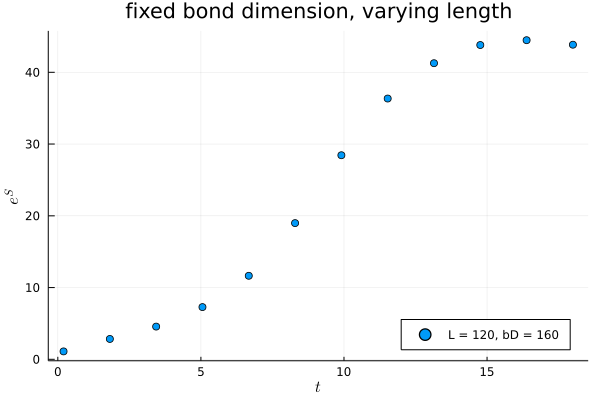

In [129]:
bonddim = length(bDs)
lege = reshape(["L = $(Ls[i]), bD = $(bDs[bonddim])" for i=1:length(Ls)], (1, length(Ls)))
scatter(times, [exp.(entropies[k][bonddim]) for k=1:length(Ls)]
    , label = lege
    , legend = :bottomright
    , title = "fixed bond dimension, varying length"
    , ylabel = L"e^S"
    , xlabel = L"t"
)



In [146]:
states[end][1][end]

MPS
[1] ((dim=2|id=169|"S=1/2,Site,n=1"), (dim=2|id=518|"Link,n=1"))
[2] ((dim=2|id=946|"S=1/2,Site,n=2"), (dim=2|id=518|"Link,n=1"), (dim=4|id=491|"Link,n=1"))
[3] ((dim=4|id=491|"Link,n=1"), (dim=2|id=889|"S=1/2,Site,n=3"), (dim=6|id=14|"Link,n=2"))
[4] ((dim=6|id=14|"Link,n=2"), (dim=2|id=508|"S=1/2,Site,n=4"), (dim=9|id=773|"Link,n=2"))
[5] ((dim=2|id=726|"S=1/2,Site,n=5"), (dim=9|id=773|"Link,n=2"), (dim=10|id=777|"Link,n=2"))
[6] ((dim=2|id=249|"S=1/2,Site,n=6"), (dim=10|id=777|"Link,n=2"), (dim=12|id=37|"Link,n=2"))
[7] ((dim=2|id=134|"S=1/2,Site,n=7"), (dim=12|id=37|"Link,n=2"), (dim=15|id=835|"Link,n=2"))
[8] ((dim=2|id=920|"S=1/2,Site,n=8"), (dim=15|id=835|"Link,n=2"), (dim=18|id=840|"Link,n=2"))
[9] ((dim=2|id=623|"S=1/2,Site,n=9"), (dim=18|id=840|"Link,n=2"), (dim=22|id=473|"Link,n=2"))
[10] ((dim=2|id=533|"S=1/2,Site,n=10"), (dim=22|id=473|"Link,n=2"), (dim=27|id=326|"Link,n=2"))
[11] ((dim=2|id=551|"S=1/2,Site,n=11"), (dim=27|id=326|"Link,n=2"), (dim=33|id=808|"Link,n=2")

## Schmidt values

This is probably needed to decide where to cut the state

In [27]:
elle = 1
max_schm_values = max_schm_vals.(states[elle][end]);

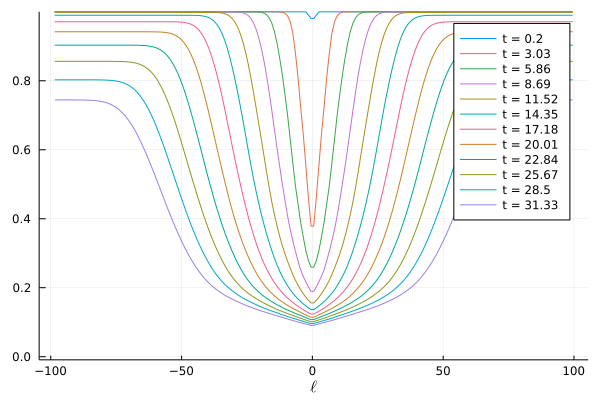

In [28]:
start = 1
finish = length(times[end])
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish-start+1))

plot(
    [[l+.5 for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:finish], max_schm_values, xlabel = L"\ell"
    #[[(l+.5)/t for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:finish], max_schm_values, xrange = (-2,2), xlabel = L"\ell/t"
    #[[(l+.5)/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:finish], max_schm_values, xrange = (-4,4), xlabel = L"\ell/\sqrt{t}"
    , yrange = (findmin(max_schm_values[end])[1]-.1, 0.99999999)#0.977)
    , label = lege
    #, xrange = (-60,-50), yrange = (0.95,1.01)
)

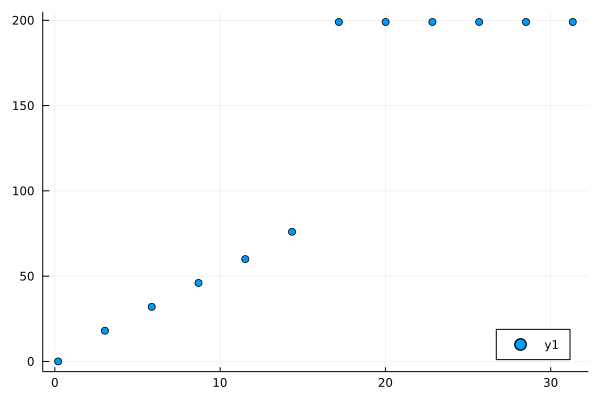

In [29]:
nnpursize = nonpurity_length.(max_schm_values)
scatter(times[elle], nnpursize, legend = :bottomright)

# Energy-related considerations DOESN'T WORK YET

## Energy density

In [64]:
energy_densities = [
    [
        [
            [hamiltonian_density(states[k][j][i], sito) for sito=2:length(states[k][j][i])-1]
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

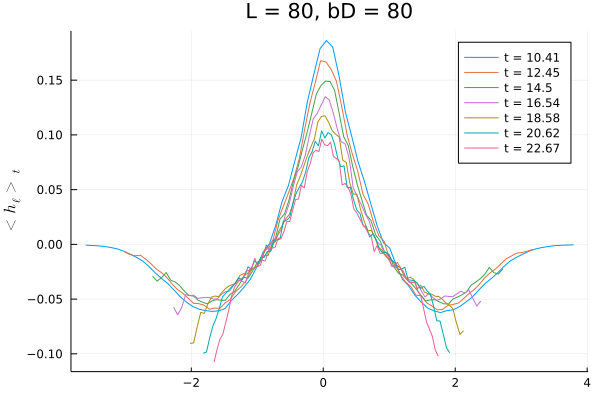

In [65]:
elle = length(Ls)
bonddim = length(bDs)
start = 6
finish = 12
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish - start+1))

plot(
    [[(l + 0.5)/t for l=2-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:end], 
    real.(energy_densities[elle][bonddim])[start:finish]
    , label = lege
    #, xrange  = (-1,1)
    #, xlabel = L"\ell/t"
    , ylabel = L"<h_\ell>_t"
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

## Total energy

In [66]:
energy_total = [
    [
        [
            sum(energy_densities[k][j][i]) + edge_energy(states[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

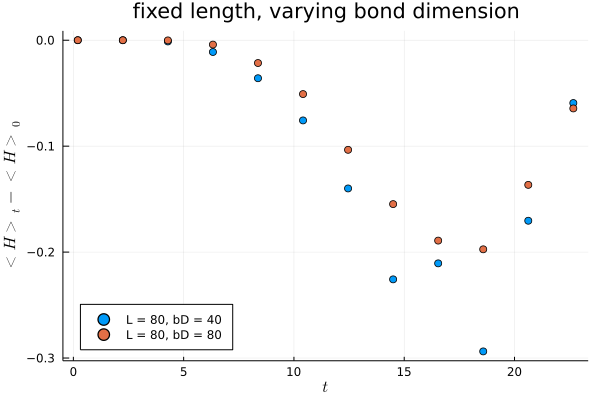

In [67]:
elle = length(Ls)

siti = siteinds("S=1/2", Ls[elle]);
state_all_up = productMPS(siti, n -> "Up");
psi0 = apply(2 * op("Sx", siti[div(Ls[elle],2)]), state_all_up);
profile0 = real.([hamiltonian_density(psi0, i) for i=2:Ls[elle]-1])
en0 = sum(profile0) + edge_energy(psi0)

lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle], [real.(energy_total[elle][j]) .- en0 for j=1:length(bDs)] 
    , label = lege
    , legend = :bottomleft
    , title = "fixed length, varying bond dimension"
    , xlabel = L"t"
    , ylabel = L"<H>_t - <H>_0"
)



In [68]:
isapprox(en0, 0)

true

# Magnetization

## standard (local magn) profile

In [13]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

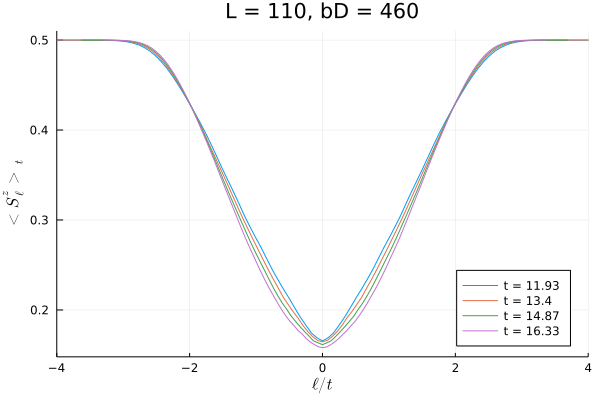

In [14]:
elle = length(Ls)
bonddim = length(bDs)
start = 9
finish = 12
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish-start+1))

plot(
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], magnetizations[elle][bonddim][start:finish], xrange  = (-4,4), xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[finish]/2] for t in times[elle]][start:finish], magnetizations[elle][bonddim][start:finish], xrange  = (-8,8), xlabel = L"\ell/\sqrt{t}"
    #magnetizations[elle][bonddim][start:finish], xlabel = L"\ell"
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

## Total magnetization

This is one of the most useful plots to understand if the behavior of the profile is ballistic or diffusive.

In [15]:
magns_tot = [[
        [
            sum(magnetizations[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

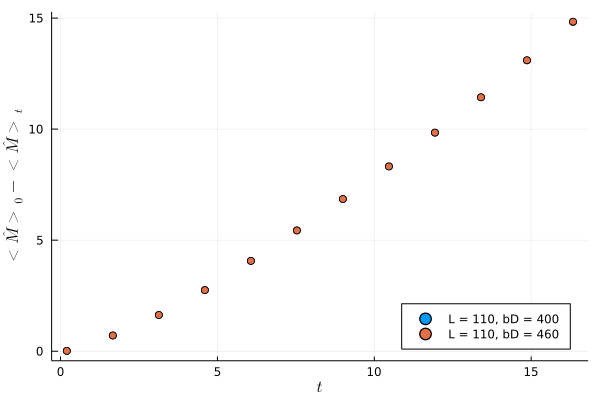

In [16]:
elle = length(Ls)
bonddim = length(bDs)
start = 1
finish = length(times[1])
lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle][start:finish], 
    [(div(Ls[elle], 2) - 1) .- magns_tot[elle][bd][start:finish] for bd=1:length(bDs)]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"<\hat{M}>_0 - <\hat{M}>_t"
    , label = lege
)


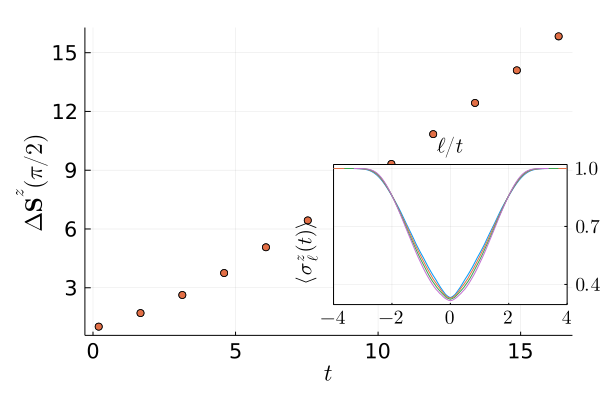

In [30]:
elle = length(Ls)
bonddim = length(bDs)
start = 1
finish = length(times[1])
lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle][start:finish], 
    [(div(Ls[elle], 2) ) .- magns_tot[elle][bd][start:finish] for bd=1:length(bDs)]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"\Delta\mathbf{S}^z(\pi/2)"
    #, label = lege
    , label = ""
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 5Plots.mm
)


elle = length(Ls)
bonddim = length(bDs)
start = length(times[1]) - 3
finish = length(times[1])
lege = reshape([L"t =" * "$(round(times[elle][i], digits=1))" for i=start:2:finish], (1,div(finish-start+1,2)))

# The call for instets is `bbox(x, y, width, height, origin...)`, 
# where numbers are treated as "percent of parent".
# For some reason I need to specify how many plots there are.
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:1:finish], 2 .* real.(magnetizations[elle][bonddim])[start:1:finish], xrange  = (-4,4), xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\sigma^z_\ell(t)\rangle\qquad"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 2
    , xticks = ([],[L"-2", L"-1", L"0", L"1", L"2"])
    , yticks = ([],[L"0.0", L"0.5", L"1.0"])
    , xmirror = :true
    , xguidefontsize = 14
    , yguidefontsize = 14
)
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:1:finish], 2 .* real.(magnetizations[elle][bonddim])[start:1:finish], xrange  = (-4,4)#, xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\sigma^z_\ell(t)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 3
    , xticks = ([-4, -2, 0, 2, 4],[L"-4", L"-2", L"0", L"2", L"4"])
    , yticks = ([0.4, 0.7, 1],[L"0.4", L"0.7", L"1.0"])
    , xtickfontsize = 13
    , ytickfontsize = 13
    , box = :on
    , ymirror = :true
)

In [31]:
#savefig("./img/paper_magn_longrange.pdf")

## Localized peak

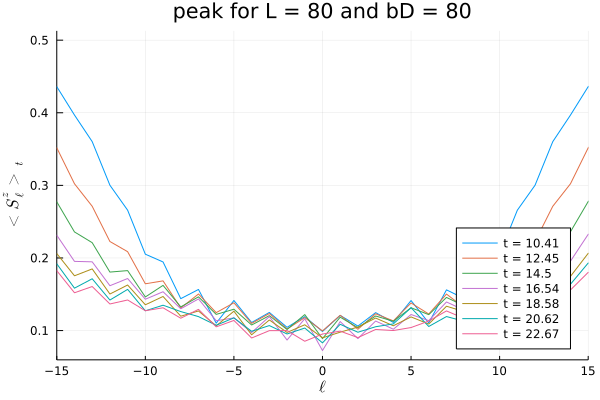

In [117]:
elle = length(Ls)
bonddim = length(bDs)
start = 6
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [l for l=1-Ls[elle]/2:Ls[elle]/2], 
    real.(magnetizations[elle][bonddim])[start:end]
    , label = lege
    , xrange  = (-15,15)
    , xlabel = L"\ell"
    , ylabel = L"<S^z_\ell>_t"
    , title = "peak for L = $(Ls[elle]) and bD = $(bDs[bonddim])"
    , legend = :bottomright
)

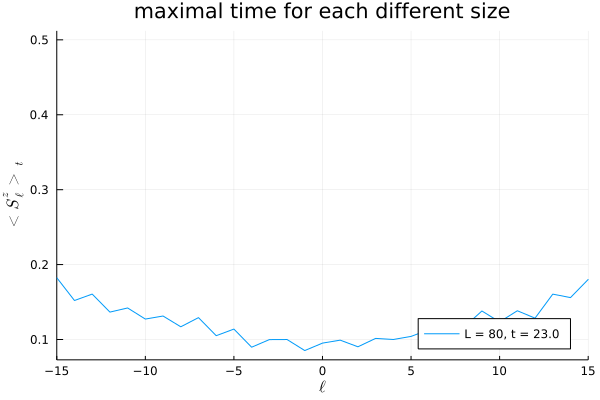

In [118]:
bonddim = length(bDs)
start = 6
plot(
    [[l for l=1-Ls[elle]/2:Ls[elle]/2] for elle=1:length(Ls)], 
    [real.(magnetizations[elle][bonddim][end]) for elle=1:length(Ls)]
    , label = reshape(["L = $(Ls[i]), t = $(round(times[i][end]))" for i=1:length(Ls)], (1,length(Ls)))
    , xrange  = (-15,15)
    , xlabel = L"\ell"
    , ylabel = L"<S^z_\ell>_t"
    , title = "maximal time for each different size"
    , legend = :bottomright
)

# Full counting statistics

## Discrete approach

This procedure is based on what Mario did in https://scipost.org/SciPostPhys.12.4.126 .
We need first to compute the **generating function of the moments of the probability distribution**, defined as

$$ G_k^{(\ell)} = <\psi| e^{i \frac{2\pi k}{2\ell+1} \hat{M}_\ell}|\psi>,$$


where $\ell$ is the size of the subsystem on which $\hat{M}$ acts (for the moment, I will consider only even $\ell$ and assume that the subsystem in centered in the origin) and 

$$ \hat{M}_\ell = \sum_{i=-\ell/2 + 1}^{\ell/2} S_i^z.$$

Finally we need to perform the discrete Fourier transform corresponding to 

\begin{equation}
\begin{aligned}
P_\ell(m) &=  \sum_{\alpha=1}^{deg(m)} |<m,\alpha|\psi>|^2 
= \sum_{n}\sum_{\alpha=1}^{deg(m)}\sum_{\beta=1}^{deg(n)} |c_{n,\beta}|^2 |<m,\alpha|n,\beta>|
\\&= \sum_{\alpha=1}^{deg(m)} |c_{m,\alpha}|^2 
= \sum_{n}\sum_{\alpha=1}^{deg(n)}  \delta_{n,m} |c_{n,\alpha}|^2 
= \frac{1}{\ell+1} \sum_{n,\alpha} \sum_{k=-\ell/2}^{\ell/2} e^{i \frac{2\pi k}{2\ell+1} (n-m)} |c_{n,\alpha}|^2
\\&= \frac{1}{\ell+1} \sum_{n,\alpha} \sum_{k=-\ell/2}^{\ell/2} e^{-i \frac{2\pi k}{\ell+1} m} |c_{n,\alpha}|^2 <n,\alpha| e^{i \frac{2\pi k}{\ell+1} \hat{M}_\ell} |n,\alpha>
\\&= \frac{1}{\ell+1} \sum_{n,\alpha}\sum_{n',\alpha'} \sum_{k=-\ell/2}^{\ell/2} e^{-i \frac{2\pi k}{\ell+1} m} c_{n,\alpha}^* c_{n',\alpha'} <n,\alpha| e^{i \frac{2\pi k}{\ell+1} \hat{M}_\ell}|n',\alpha'>
\\&= \frac{1}{\ell+1} \sum_{k=-\ell/2}^{\ell/2} e^{-i \frac{2\pi k}{\ell+1} m} <\psi| e^{i \frac{2\pi k}{\ell+1} \hat{M}_\ell}|\psi>
= \frac{1}{\ell+1} \sum_{k=-\ell/2}^{\ell/2} e^{-i \frac{2\pi k}{\ell+1} m} G^{(\ell)}_k
\end{aligned}
\end{equation}


that is the probability to measure $m$ looking at the observable $\hat{M}_\ell$ if the system is in the state $\psi$. Note that $m$ can only assume semi-integer values; specifically, it assumes values in the interval $\{-\ell/2, -(\ell-1)/2,...,\ell/2\}$. In fact, note that only integer values of $\hat{M}_\ell$ are possible, since we are considering an even number of spins, and I used that in the proof above.

In [78]:
function eiM(θ, psi, ell) 
    siti = siteinds(psi)
    lunghezza = length(psi)
    outpu = ITensor[]
    for j in siti[- div(ell, 2) + 1 + div(lunghezza, 2) : div(ell, 2) + div(lunghezza, 2)]
        ope = op("Sz", j)
        push!(outpu, exp(2im * pi * θ * ope / (ell + 1)))
    end
    outpu
end

G(state, ell) = [inner(state, apply(eiM(k, state, ell), state)) for k=-div(ell, 2):div(ell, 2)]

G (generic function with 1 method)

In [79]:
function full_counting_ofZ(state, ell)
    Gk = G(state, ell)
    outpu = ComplexF64[]
    rangeh = div(ell, 2)
    for m = -rangeh:rangeh
        expophase = [exp(- 2im * pi * k * m / (ell + 1)) for k=-rangeh:rangeh]
        push!(outpu, sum(expophase .* Gk) / (ell + 1))
    end
    outpu
end
        

full_counting_ofZ (generic function with 1 method)

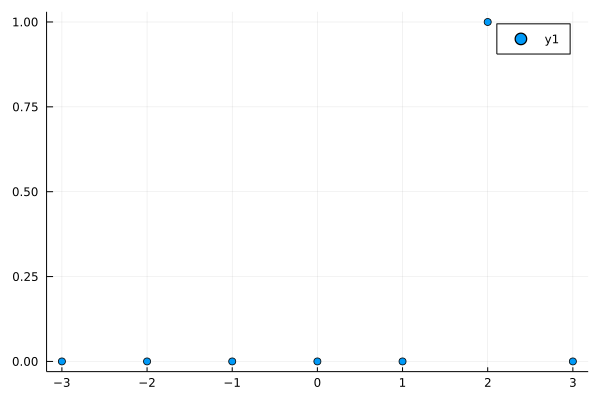

In [62]:
# check for the initial product state
elle = 1

siti = siteinds("S=1/2", Ls[elle]);
state_all_up = productMPS(siti, n -> "Up");
psi0 = apply(2 * op("Sx", siti[div(Ls[elle],2)]), state_all_up);

full_countedZ = real.(full_counting_ofZ(psi0, 6))
scatter([j for j=-div(length(full_countedZ), 2):div(length(full_countedZ), 2)], full_countedZ)

## Further analysis

Given the full counting statistics, we can compute mean and variance of the distribution. We kinda know that the variance is directly linked to the macroscopic entanglement (if it grows a (system size)^2, or in our case, as time^2 (it is equivalente, given our lightcone structure). 

In [80]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


varianceFCS (generic function with 1 method)

In [81]:
elle = length(Ls)
subsys = Ls[elle]

full_countedZs = [
    [
        real(full_counting_ofZ(states[elle][bd][i], subsys)) 
        for i=1:length(times[elle])
    ] for bd = length(bDs):length(bDs)
];

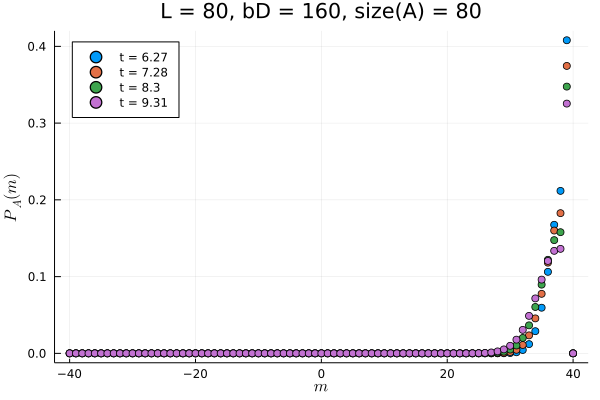

In [82]:
oneortwo = 1
start = 7
finish = 10
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(subsys, 2):div(subsys, 2)], 
    full_countedZs[oneortwo][start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[end]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

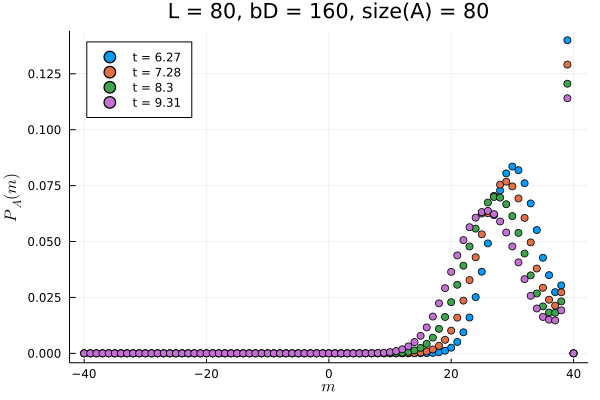

In [72]:
oneortwo = 1
start = 7
finish = 10
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(subsys, 2):div(subsys, 2)], 
    full_countedZs[oneortwo][start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[end]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

In [186]:
#savefig("./img/FIGfullcounting_longrangeXXXn2.pdf")
#savefig("./img/FIGfullcounting_longrangeXXZn2.pdf")

In [181]:
mean_magnetizations = [meanFCS.(full_countedZs[bd]) for bd = 1:2];
magnetization_variances = [varianceFCS.(full_countedZs[bd]) for bd = 1:2];

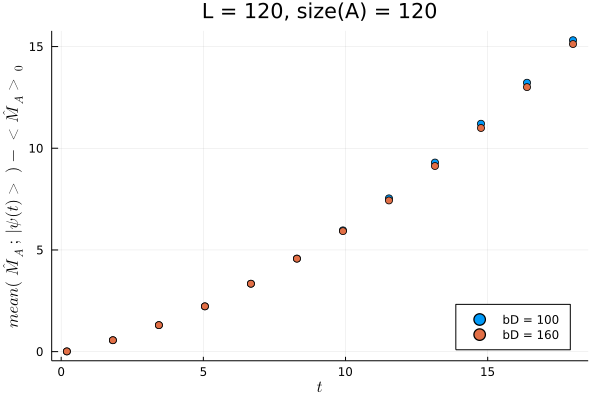

In [182]:
lege = reshape(["bD = $(bDs[i])" for i = length(bDs)-1:length(bDs)], (1,2))

scatter(times[elle], 
    [(div(Ls[elle], 2) - 1) .- mean_magnetizations[bd] for bd=1:2]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"mean(~\hat{M}_A~; ~|\psi(t)>~) - <\hat{M}_A>_0"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

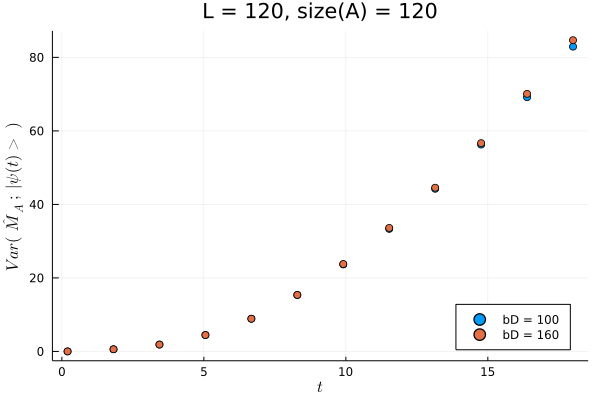

In [187]:
lege = reshape(["bD = $(bDs[i])" for i = length(bDs)-1:length(bDs)], (1,2))

scatter(times[elle], 
    magnetization_variances
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

In [188]:
#savefig("./img/FIGvariance_longrangeXXXn2.pdf")
#savefig("./img/FIGvariance_longrangeXXZn2.pdf")

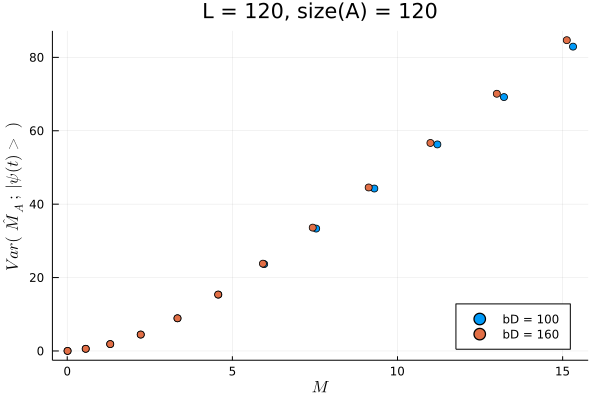

In [189]:
lege = reshape(["bD = $(bDs[i])" for i = length(bDs)-1:length(bDs)], (1,2))

scatter([(div(Ls[elle], 2) - 1) .- mean_magnetizations[bd] for bd=1:2], 
    magnetization_variances
    , legend = :bottomright
    , xlabel = L"M"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

In [190]:
#savefig("./img/FIGvarVSmagn_longrangeXXXn2.pdf")
#savefig("./img/FIGvarVSmagn_longrangeXXZn2.pdf")

In [212]:
elle = 1
max_schm_values12 = [max_schm_vals.(states[elle][end-1]), max_schm_vals.(states[elle][end])];
nnpur12 = [nonpurity_length.(max_schm_values12[1]), nonpurity_length.(max_schm_values12[2])]

2-element Vector{Vector{Int64}}:
 [0, 10, 20, 28, 36, 44, 52, 62, 72, 84, 119, 119]
 [0, 10, 20, 28, 36, 44, 52, 60, 70, 80, 119, 119]

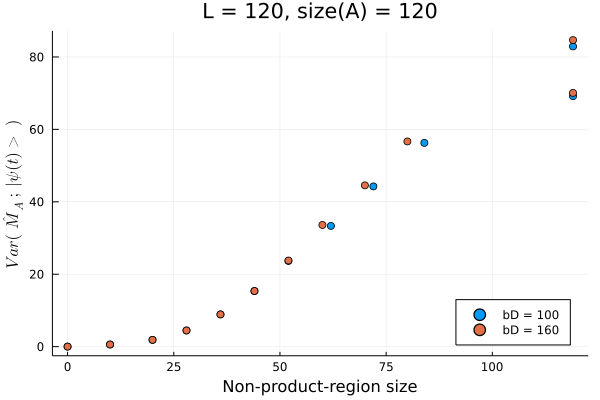

In [234]:
lege = reshape(["bD = $(bDs[i])" for i = length(bDs)-1:length(bDs)], (1,2))

scatter(nnpur12, 
    magnetization_variances
    , legend = :bottomright
    , xlabel = "Non-product-region size"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

In [235]:
#savefig("./img/FIGvarVSpurity_longrangeXXXn2.pdf")
#savefig("./img/FIGvarVSpurity_longrangeXXZn2.pdf")

Let's do a sanity check: the mean magnetizations obtained from the full counted statistics must coincide with the total magnetization computed earlier in this notebook.

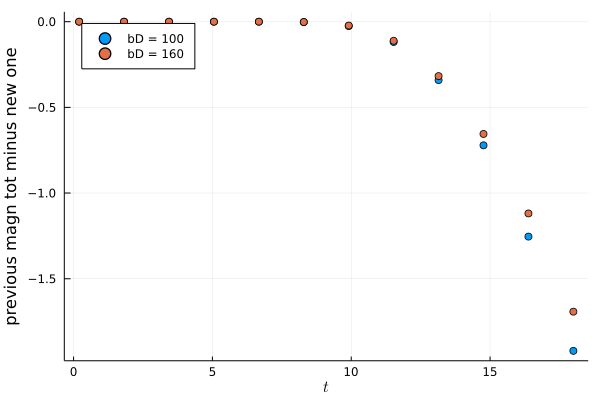

In [338]:
lege = reshape(["bD = $(bDs[i])" for i = 1:length(bDs)], (1,length(bDs)))

scatter(times[elle],
    [mean_magnetizations[length(bDs)] .- magns_tot[elle][bd] for bd = 1:length(bDs)]
    , xlabel = L"t"
    , label = lege
    , legend = :topleft
    , yaxis = "previous magn tot minus new one"
)

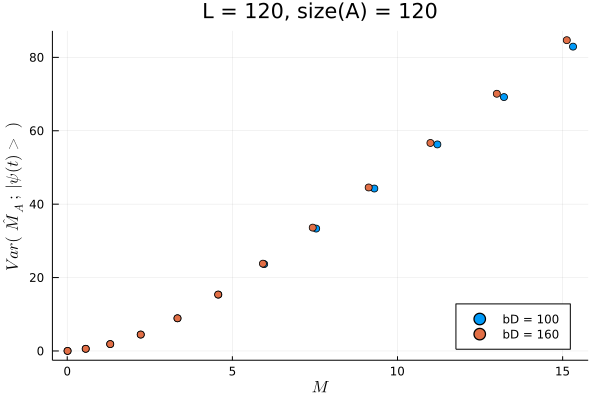

In [332]:
lege = reshape(["bD = $(bDs[i])" for i = length(bDs)-1:length(bDs)], (1,2))

scatter([(div(Ls[elle], 2) - 1) .- mean_magnetizations[bd] for bd=1:2], 
    magnetization_variances
    , legend = :bottomright
    , xlabel = L"M"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

### Saving the result

In [340]:
# for laptop:
whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics";

# for desktop
#whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics";

In [343]:
df = DataFrame([full_countedZs[2][i][j] for j=1:length(full_countedZs[2][1]), i=1:length(full_countedZs[2])], :auto)
rename!(df, Symbol.(times[1]))
#save("$(whereto)/LongrangeXXZ/n$(nmax)_L$(Ls[elle])_Jx$(Jx)_Jz$(Jz)_g$(g)_dt$(dt)_bD$(bDs[length(bDs)-2+oneortwo]).csv", df)

## Using saved results

Given the full counting statistics, we can compute mean and variance of the distribution. We kinda know that the variance is directly linked to the macroscopic entanglement (if it grows a (system size)^2, or in our case, as time^2 (it is equivalente, given our lightcone structure). 

In [18]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


varianceFCS (generic function with 1 method)

In [19]:
# for laptop:
#whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics";

# for desktop
whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics";

In [20]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

whereto2 = "longrange/XXZ/n$(nmax)_L$(Ls[elle])_Jx$(Jx)_Jz$(Jz)_g$(g)_dt$(dt)"

result_loaded = DataFrame(load("$(whereto)/$(whereto2)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1 = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/$(whereto2)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2 = [result_loaded[!, i] for i = 1:length(imported_times)];

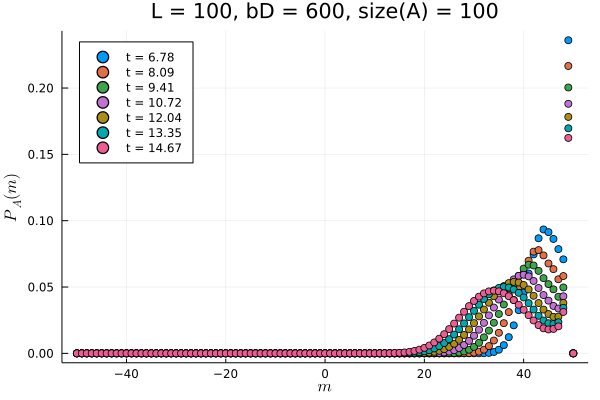

In [29]:
start = 6
finish = 12
lege = reshape(["t = $(round(imported_times[i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end])"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

In [31]:
#savefig("./img/FIGfullcounting_longrangeXXZn2.pdf")

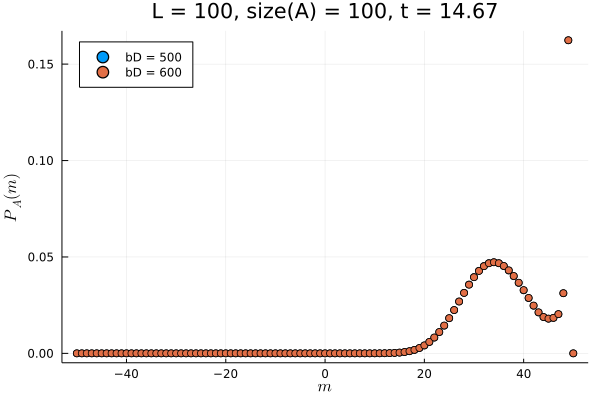

In [22]:
tt = 12

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[tt]
    , label = "bD = $(bDs[end])"
)

In [33]:
[sum(imported_fcs1[tt]), sum(imported_fcs2[tt])]

2-element Vector{Float64}:
 0.9987262958968567
 0.9990346910067136

In [34]:
#savefig("./img/FIGfullcountingSTABILITY_longrangeXXZn2_2.pdf")

In [23]:
mean_magnetization1 = meanFCS.(imported_fcs1) 
magnetization_variance1 = varianceFCS.(imported_fcs1) 

mean_magnetization2 = meanFCS.(imported_fcs2) 
magnetization_variance2 = varianceFCS.(imported_fcs2) ;

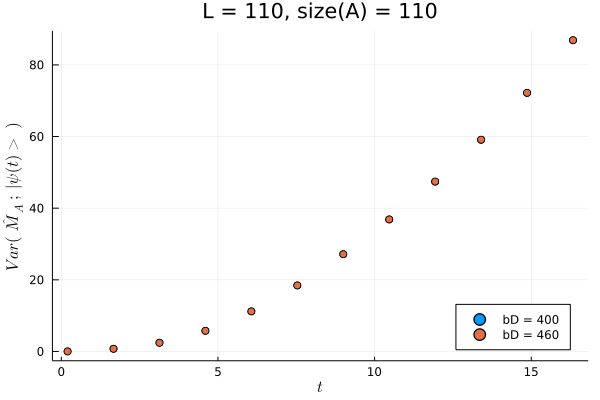

In [55]:
finish = 12

scatter(times[length(Ls)][1:finish], 
    magnetization_variance1[1:finish]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = "bD = $(bDs[end-1])"
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end])"
)

scatter!(times[length(Ls)][1:finish], 
    magnetization_variance2[1:finish]
    , label = "bD = $(bDs[end])"
)

In [72]:
#savefig("./img/FIGvariance_longrangeXXZn2.pdf")

In [52]:
elle = length(Ls)
max_schm_values12 = [max_schm_vals.(states[elle][end-1][1:finish]), max_schm_vals.(states[elle][end][1:finish])];
nnpur12 = [nonpurity_length.(max_schm_values12[1]), nonpurity_length.(max_schm_values12[2])]

2-element Vector{Vector{Int64}}:
 [0, 10, 18, 26, 34, 40, 48, 56, 62, 70, 78, 90]
 [0, 10, 18, 26, 34, 40, 48, 56, 62, 70, 78, 88]

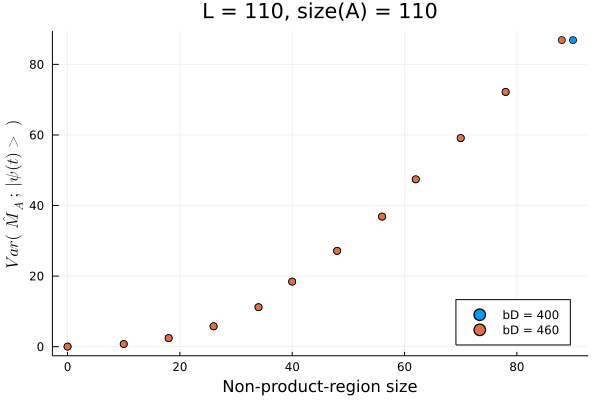

In [53]:
scatter(nnpur12[1][1:finish], 
    magnetization_variance1[1:finish]
    , legend = :bottomright
    , xlabel = "Non-product-region size"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = "bD = $(bDs[end-1])"
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end])"
)

scatter!(nnpur12[2][1:finish], 
    magnetization_variance2[1:finish]
    , label = "bD = $(bDs[end])"
)

In [77]:
#savefig("./img/FIGvarVSpurity_longrangeXXZn2.pdf")

# Overlaps with initial state

In [29]:
ols1 = Float64[]
elle = 1
bonddim = length(bDs)-1


for tt = 1:length(times[elle])
    siti = siteinds(states[elle][bonddim][tt]);
    state_all_up = productMPS(siti, n -> "Up");
    psi0 = apply(2 * op("Sx", siti[div(Ls[elle],2)]), state_all_up);

    push!(ols1, norm(inner(psi0, states[elle][bonddim][tt])))
end

In [30]:
ols2 = Float64[]
elle = 1
bonddim = length(bDs)


for tt = 1:length(times[elle])
    siti = siteinds(states[elle][bonddim][tt]);
    state_all_up = productMPS(siti, n -> "Up");
    psi0 = apply(2 * op("Sx", siti[div(Ls[elle],2)]), state_all_up);

    push!(ols2, norm(inner(psi0, states[elle][bonddim][tt])))
end

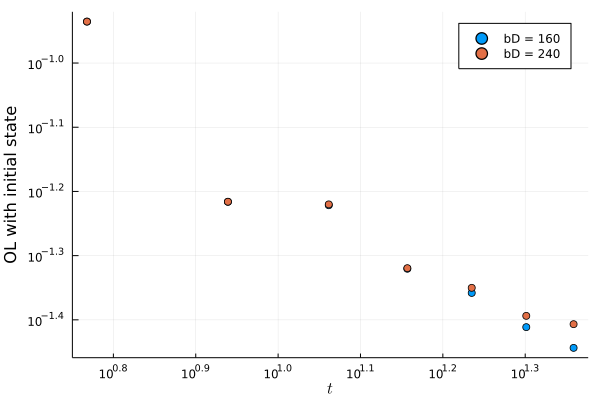

In [41]:
start = 3
finish = 9

scatter(times[elle][start:finish], ols1[start:finish]
    , xaxis = :log10
    , yaxis=:log10
    , label = "bD = $(bDs[end-1])"
    , xlabel = L"t"
    , ylabel = "OL with initial state"
)
scatter!(times[elle][start:finish], ols2[start:finish], xaxis = :log10, yaxis=:log10, label = "bD = $(bDs[end])")
#plot!(x->0.0000000001, 1:10)

# Full counting of X

In [8]:
function eiM_forX(θ, psi, ell) 
    siti = siteinds(psi)
    lunghezza = length(psi)
    outpu = ITensor[]
    for j in siti[- div(ell, 2) + 1 + div(lunghezza, 2) : div(ell, 2) + div(lunghezza, 2)]
        ope = op("Sx", j)
        push!(outpu, exp(2im * pi * θ * ope / (ell + 1)))
    end
    outpu
end

G_forX(state, ell) = [inner(state, apply(eiM_forX(k, state, ell), state)) for k=-div(ell, 2):div(ell, 2)]

G_forX (generic function with 1 method)

In [9]:
function full_counting_ofX(state, ell)
    Gk = G_forX(state, ell)
    outpu = ComplexF64[]
    rangeh = div(ell, 2)
    for m = -rangeh:rangeh
        expophase = [exp(- 2im * pi * k * m / (ell + 1)) for k=-rangeh:rangeh]
        push!(outpu, sum(expophase .* Gk) / (ell + 1))
    end
    outpu
end
        

full_counting_ofX (generic function with 1 method)

In [10]:
elle = 1
bonddim = 1
subsys = Ls[elle]

full_countedXs = [
    [
        real(full_counting_ofX(states[elle][bd][i], subsys)) 
        for i=1:length(times[elle])
    ] for bd = bonddim:bonddim
];

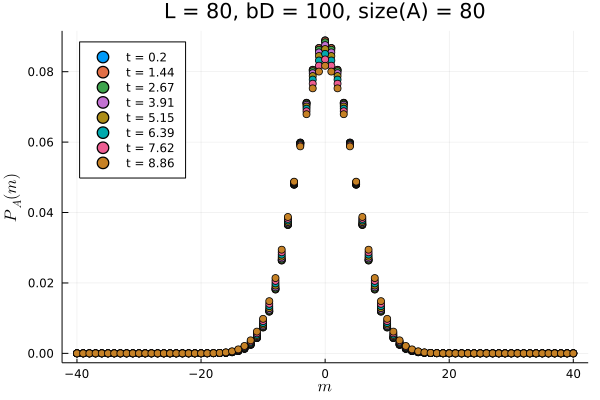

In [12]:
start = 1
finish = 8
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(subsys, 2):div(subsys, 2)], 
    full_countedXs[end][start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

# Quantum Fisher

This uses the results obtained from the Mathematica algorithm written by Mau.

In [19]:
# for laptop:
#whereto = "/Users/saveriobocini/numerics_PhD/fishers";

# for desktop
whereto = "/home/sbocini/Numerics_LabDesktop/fishers";

In [20]:
elle = length(Ls)

QFI_flip = CSV.read("$(whereto)/longrange/XXZ/n$(nmax)_L$(Ls[elle])_Jx$(Jx)_Jz$(Jz)_g$(g)_BondDim$(bDs[end])_dt$(dt)_FLIP.csv", DataFrame, header=0)

QFI_cat = CSV.read("$(whereto)/longrange/XXZ/n$(nmax)_L$(Ls[elle])_Jx$(Jx)_Jz$(Jz)_g$(g)_BondDim$(bDs[end])_dt$(dt)_CAT.csv", DataFrame, header=0);


In [21]:
start = 3
finish = 10

m(t, p) = p[1] .+ p[2] * t + p[3] ./ t
p0 = [0.5, 0.5, 0.5]
fitte1 = curve_fit(m, QFI_flip.Column1[start:finish], QFI_flip.Column2[start:finish], p0);
fit_flip(t) = m(t, fitte1.param);

m(t, p) = p[1] .+ p[2] * t + p[3] ./ t
p0 = [0.5, 0.5, 0.5]
fitte2 = curve_fit(m, QFI_cat.Column1[start:finish], QFI_cat.Column2[start:finish], p0);
fit_cat(t) = m(t, fitte2.param);

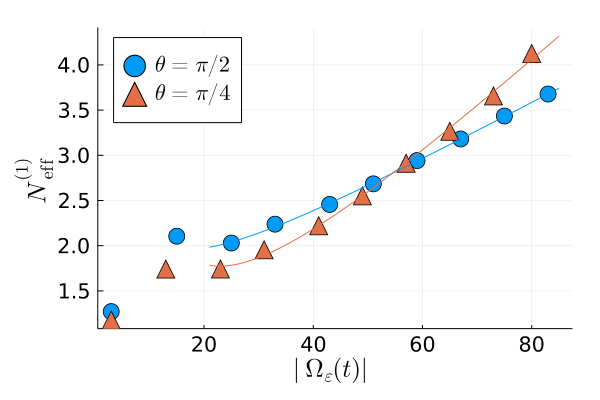

In [25]:
scatter(QFI_flip.Column1, QFI_flip.Column2
    , label = L"\theta=\pi/2"
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"|\Omega_\epsilon(t)|"
    , ylabel = L"N_{\mathrm{eff}}^{(1)}"
    #, xrange = (-4.8, 4.8)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 17
    , yguidefontsize = 17
    , legendfontsize = 15
    , markersize = 9
    , margins = 5Plots.mm
)

scatter!(QFI_cat.Column1, QFI_cat.Column2
    , label = L"\theta=\pi/4"
    , markersize = 9
    , shape = :utriangle
)

leftone = findmin([QFI_flip.Column1[3], QFI_cat.Column1[3]])[1] - 2
rightone = findmax([QFI_flip.Column1[end], QFI_cat.Column1[end]])[1] + 2

plot!(leftone:0.01:rightone, fit_flip(leftone:0.01:rightone)
    , label = ""
    , color = 1
)

plot!(leftone:0.01:rightone, fit_cat(leftone:0.01:rightone)
    , label = ""
    , color = 2
)


In [26]:
#savefig("./img/paper_fishers_longrangeXXZ.pdf")

# Evolving first with Ising

## Loading

In [4]:
n = 2
Jx = 0.25
Jz = 0.1
g = 0.18
dt = 0.01;

Ls = [60]
bDs = [300];

In [14]:
n = 2
Jx = 0.25
Jz = 0.12
g = 0.18
dt = 0.01;

Ls = [80]
bDs = [340, 400];

In [5]:
n = 2
Jx = 0.25
Jz = 0.12
g = 0.18
dt = 0.01;

Ls = [100]
bDs = [500];

In [6]:
# for laptop:
base_path = "/Users/saveriobocini/numerics_PhD/longrange/XXZ_after_ising";

# for desktop
#base_path = "/home/sbocini/Numerics_LabDesktop/longrange/XXZ_after_ising";


times = [
    load("$(base_path)/n$(n)_L$(L)_Jx$(Jx)_Jz$(Jz)_g$(g)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
];

states = [
    [
        [
            load("$(base_path)/n$(n)_L$(Ls[k])_Jx$(Jx)_Jz$(Jz)_g$(g)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [7]:
times

1-element Vector{Vector{Float64}}:
 [0.4, 1.6, 2.8, 3.9999999999999996, 5.2, 6.4, 7.6, 8.8, 10.0]

## Magnetization

In [8]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

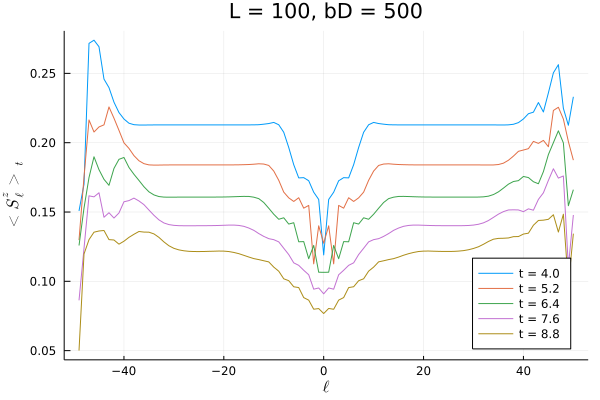

In [12]:
elle = length(Ls)
bonddim = length(bDs)
start = 4
finish = 8
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], magnetizations[elle][bonddim][start:finish], xlabel = L"\ell"
    #[[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], magnetizations[elle][bonddim][start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], magnetizations[elle][bonddim][start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

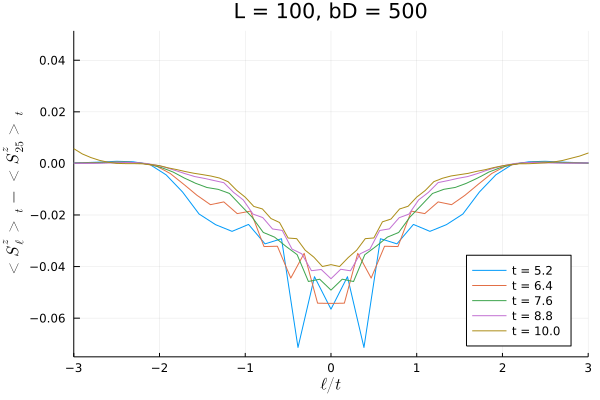

In [27]:
elle = length(Ls)
bonddim = length(bDs)
start = 5
finish = 9
ref_point = 25
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], [magnetizations[elle][bonddim][i] .- magnetizations[elle][bonddim][i][ref_point] for i=start:finish], xrange=(-ref_point,ref_point), xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], [magnetizations[elle][bonddim][i] .- magnetizations[elle][bonddim][i][ref_point] for i=start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], [magnetizations[elle][bonddim][i] .- magnetizations[elle][bonddim][i][ref_point] for i=start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^z_\ell>_t - <S^z_{25}>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

## Other local observables

In [111]:
elle = length(Ls)
bonddim = length(bDs)

XXcorrs = [
    [
        real(XXcorr(states[elle][bonddim][t], i, i+1))
        for i = 1:Ls[elle]-1
    ] for t = 1:length(times[elle])
];

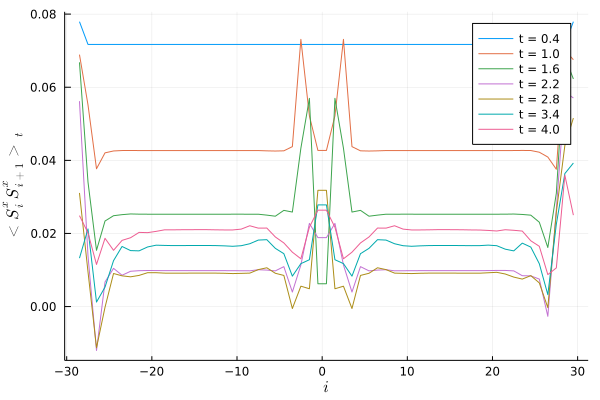

In [112]:
start = 1
finish = 5
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l+0.5 for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:end], XXcorrs
    , label = lege
    , xlabel = L"i"
    , ylabel = L"<S^x_i S^x_{i+1}>_t"
)

## Energy

In [20]:
tot_energies = [inner(states[end][end][i], apply(H_tobeapplied(states[end][end][i]), states[end][end][i])) for i = 1:length(states[end][end])]
;

LoadError: UndefVarError: H_tobeapplied not defined

In [114]:
scatter(times[end], real.(tot_energies) .- real.(tot_energies[1])
    , xlabel = L"t"
    , ylabel = L"E_{tot}(t) - E_{tot}(0)"
    , label = ""
)

LoadError: UndefVarError: tot_energies not defined